# Statistical Foundations of Machine Learning: Project

## Introduction
This notebook was created as part of the coursework for Statistical Foundations of Machine Learning, a master's course in Artificial Intelligence at the VUB (Vrije Universiteit Brussel). In this interactive notebook we will try to answer 3 research questions by applying ML algorithms to both synthetic and real datasets.

Before this running this notebook, please install the following python packages: 
- numpy
- scipy
- scikit-learn
- ...

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import pandas as pd
from scipy import stats
import scipy as sp

Generating a synthetic classification dataset in 2 dimensions. Datapoints are uniformly distributed in the 2 dimensional input plane. The classification of the points is decided by a user defined separation_boundary.

In [3]:
def generate_uniform_classification_data(n, separation_boundary, x0min=0, x0max=1, x1min=0, x1max=1):
    x0distr = stats.uniform(loc=x0min, scale=x0max-x0min)
    x1distr = stats.uniform(loc=x1min, scale=x1max-x1min)
    x0s = x0distr.rvs(size=n)
    x1s = x1distr.rvs(size=n)
    X = np.array(list(zip(x0s, x1s)))
    y = np.sign([separation_boundary(xi) for xi in X])
    y = np.where(y == 0, 1, y)
    return X, y

def generate_normally_distributed_points(n, means, co_variances):
    distr = stats.multivariate_normal(means, co_variances)
    ### Code from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html#scipy.stats.multivariate_normal    
    
    return distr.rvs(size=n)

def generate_regression_data(n, target, xdistr=stats.uniform(), noise_var=0):
    noise_distr = stats.norm(scale=noise_var)
    x = xdistr.rvs(n)
    y = target(x)
    noise = noise_distr.rvs(n)
    y = y + noise
    return x, y

def plot_labeled_data(X, y):
    posX = X[np.where(y == 1)]
    negX = X[np.where(y == -1)]
    plt.plot(posX[:,0], posX[:,1], 'r.')
    plt.plot(negX[:,0], negX[:,1], 'b.')


## Research Question 1

## Research Question 2
The second question we aim to answer in this notebook, is how the distribution of input-variables of datapoints affects a regression algorithm's ability to fit the data. This is an interesting thing to investigate because real data is not always uniformly distributed. For example a people's heights tend to be normally distributed. In this section, we will fit multiple regression algorithms to several synthetic datasets that had their datapoints generated from different types of distributions. We will be working with only 1 input dimension since this makes it easier for us to plot the data.

In [4]:
### Some functions to help us visualise ###
def plot_function(function, range=(0, 1), ax=plt):
    line = ax.plot(np.linspace(range[0], range[1], 100), function(np.linspace(range[0], range[1], 100)))
    return ax, line[0]

def plot_data(x, y, ax=plt):
    line = ax.scatter(x, y)
    return ax, line

def plot_data_cdf(x, ax=plt):
    sorted = np.sort(x)
    p = np.arange(len(x)) / (len(x) - 1)
    line = ax.plot(sorted, p)
    return ax, line[0]

def plot_distr_cdf(distr, range=(0, 1), ax=plt):
    return plot_function(distr.cdf, range, ax)

def plot_distr_pdf(distr, range=(0, 1), ax=plt):
    return plot_function(distr.pdf, range, ax)

def plot_distrs(x, distr, range=(0, 1), ax=plt):
    _, line = plot_data_cdf(x, ax)
    line.set_label("Data CDF")
    _, line = plot_distr_cdf(distr, range=range, ax=ax)
    line.set_label("Distribution CDF")
    ax.legend()
    return ax

def minmax(x):
    return (min(x), max(x))

def multiply_fig_size(fig, row, col):
    size = np.array(fig.get_size_inches()) * np.array([col, row])
    fig.set_size_inches(size)
    return fig


We will test the algorithms on various distributions of input data. The distributions we will be using are a uniform distribution (as a baseline), a normal distribution and an exponential distribution. We shift, scale and truncate the distributions to be in the range [0, 1]. The range in which the generated points fall, which is decided by the distribution, influences which part of the target function the algorithm will try to fit. By bringing each of these distributions to the same range, we ensure a fair comparison. The distributions are scaled by a factor 0.2, at which point around 99% of the values for the non-truncated version will fall in the range [0, 1].

To visualise how these distributions generate their datapoints, we plot the probability density and cummulative density functions for each of them in the cell below. I also include graphs visualising the similarity between the distributions and their truncated version in the interval [0, 1].

A normal distribution with mean 0.5 and std 0.2 has 99% of its values in the range [-0.01516586070978021, 1.01516586070978]
A exponential distribution with scale 0.2 has 99% of its values in range [0, 0.9210340371976182]


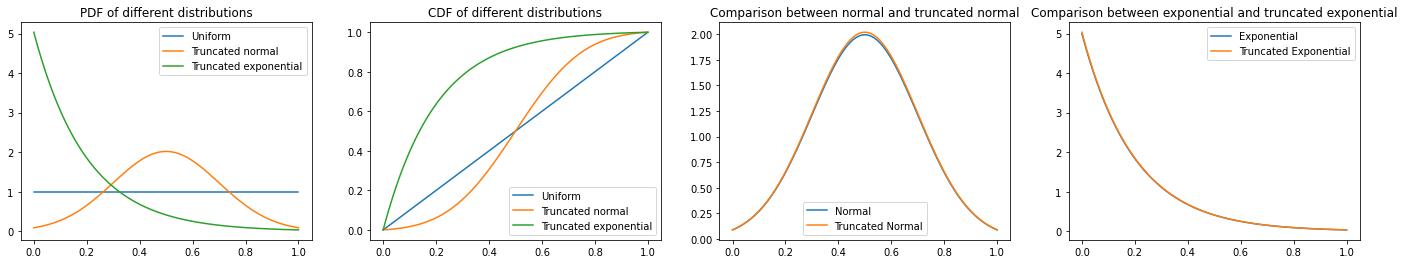

In [65]:
### Different distributions we'll be using
# We try to bring all the different distribution between 0 and 1 to ensure a fair comparison between algorithms (target function might be different in different parts of the domain)

# Uniform distribution
def uniform():
    return stats.uniform()

# Truncated normal distribution
def trunc_norm(mean=0.5, std=0.2):
    a, b, mu, sig = 0, 1, mean, std
    ### --- Code adapted from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html#notes
    a, b = (a - mu) / sig, (b - mu) / sig
    ### --- It updates the boundaries of the normal distribution based on the mean and std
    xdistr = stats.truncnorm(a, b, loc=mu, scale=sig)
    return xdistr

# Truncated exponential
def trunc_expon(scale=0.2):
    return stats.truncexpon(1/scale, loc=0, scale=scale)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
multiply_fig_size(fig, 1, 4)

# Visualise uniform distribution
uniform_distr = uniform()
_, line = plot_distr_pdf(uniform_distr, ax=ax1)
line.set_label("Uniform")
_, line = plot_distr_cdf(uniform_distr, ax=ax2)
line.set_label("Uniform")

# Visualise truncated normal distribution
mean, std = 0.5, 0.2
trunc_norm_distr = trunc_norm(mean, std)
uniform_distr = uniform()
_, line = plot_distr_pdf(trunc_norm_distr, ax=ax1)
line.set_label("Truncated normal")
_, line = plot_distr_cdf(trunc_norm_distr, ax=ax2)
line.set_label("Truncated normal")

normal_distr = stats.norm(loc=mean, scale=std)
print(f"A normal distribution with mean {mean} and std {std} has 99% of its values in the range [{normal_distr.ppf(0.005)}, {normal_distr.ppf(0.995)}]")

# Plot difference between normal and truncated_normal
plot_distr_pdf(normal_distr, ax=ax3)[1].set_label("Normal")
plot_distr_pdf(trunc_norm_distr, ax=ax3)[1].set_label("Truncated Normal")
ax3.set_title("Comparison between normal and truncated normal")
ax3.legend()

# Visualise truncated exponential distribution
scale = 0.20
trunc_expon_distr = trunc_expon(scale)
_, line = plot_distr_pdf(trunc_expon_distr, ax=ax1)
line.set_label("Truncated exponential")
_, line = plot_distr_cdf(trunc_expon_distr, ax=ax2)
line.set_label("Truncated exponential")

expon_distr = stats.expon(scale=scale)
print(f"A exponential distribution with scale {scale} has 99% of its values in range [0, {expon_distr.ppf(0.99)}]")

# Plot difference between exponential and exponential
plot_distr_pdf(expon_distr, ax=ax4)[1].set_label("Exponential")
plot_distr_pdf(trunc_expon_distr, ax=ax4)[1].set_label("Truncated Exponential")
ax4.set_title("Comparison between exponential and truncated exponential")
ax4.legend()


distrs = [uniform_distr, trunc_norm_distr, trunc_expon_distr]
distr_names = ["uniform", "truncated normal", "truncated exponential"]

ax1.set_title("PDF of different distributions")
ax2.set_title("CDF of different distributions")
ax1.legend()
ax2.legend()


## Algorithms
We'll attempt to fit the target functions using different regression algorithms.
The first algorithms we'll use is the Kernel Ridge Regression algorithm. As the name suggests this is a Ridge Regression algorithm that uses the kernel trick to transform data to a (higher dimension) feature space. The Ridge Regression algorithm fits the data


In [6]:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

algorithms = [SVR, KNeighborsRegressor]
algorithm_names = ["SVR", "KNN"]

**EXPLAIN ALGORITHMS**
### SVR
The first algorithm I'll be using is the support vector regressor (SVR). It is an extension to the support vector classifier algorithm

### KNN

In [7]:
def plot_prediction(x, y, target_function, model, range=False, ax=plt):
    prediction = make_prediction_function(model)
    if not range:
        range = minmax(x)
    # Plot the target function
    _, line = plot_function(target_function, range=range, ax=ax)
    line.set_label("Target function")
    line.set_color("r")
    line.set_linestyle("--")
    # Plot the predicted curve
    _, line = plot_function(prediction, range=range, ax=ax)
    line.set_label("Predicted")
    # Plot datapoints (+ support vectors in case of SVR)
    if type(model) == skl.svm._classes.SVR:
        support_vectors = model.support_vectors_
        support_vector_idx = [x in support_vectors for x in x]

        _, line = plot_data(np.array(x)[np.where(np.invert(support_vector_idx))], np.array(y)[np.where(np.invert(support_vector_idx))], ax=ax)
        line.set_label("Data points")

        support_vectors = np.array(x)[np.where(support_vector_idx)]
        support_vector_ys = np.array(y)[np.where(support_vector_idx)]
        _, line = plot_data(support_vectors, support_vector_ys, ax=ax)
        line.set_color("r")
        line.set_label("Support Vectors")
    else:
        _, line = plot_data(x, y, ax=ax)
        line.set_label("Data points")
    ax.legend()
            
def fit_models(x, y):
    #fit the SVR
    svr = SVR()
    svr.fit(X=x.reshape(-1, 1), y=y)

    #fit the KNN
    knn = KNeighborsRegressor()
    knn.fit(X=x.reshape(-1, 1), y=y)

    return svr, knn

def plot_results(result_dicts, axss):
    for result, distr, name, axs in zip(result_dicts.values(), distrs, result_dicts.keys(), axss):
        plot_results_for_distribution(result["x"], result["y"], distr, name, result["target"], result["svr"], result["knn"], axs)    

def plot_results_for_distribution(x, y, distr, distr_name, target_function, svr, knn, axs):
    assert(len(axs) == 3)
    ax1, ax2, ax3 = axs
    if ax1:
        plot_distrs(x, distr, range=(0, 1), ax=ax1)
        ax1.set_title(f"CDFs for {distr_name} distribution")
    if ax2:
        plot_prediction(x, y, target_function, svr, range=(0, 1), ax=ax2)
        ax2.set_title(f"SVR on {distr_name} distribution")
    if ax3:
        plot_prediction(x, y, target_function, knn, range=(0, 1), ax=ax3)
        ax3.set_title(f"KNN on {distr_name} distribution")
    
def make_prediction_function(model):
    return lambda x: model.predict(x.reshape(-1, 1))


We can now start training and evaluating the algorithms using the different distributions of datapoints. We start by generating a target function we want our models to learn. We then generate equally sized datasets for each of the different data distributions we are examining. Each algorithm is then applied to each dataset. 

Finally we evaluate the trained models. Since we know the target function in these examples, we can directly evaluate the models by generating some datapoints and their corresponding values. We choose these points uniformly spread over the [0, 1] domain. However, the original data was not always drawn from a uniform distribution. To fix this, we weigh the contribution of each datapoint to the final score by its value in the probability density function of the distribution we are examining. This way points that would have had only a small chance of being generate, contribute less to the final score.

We repeat this process for multiple iterations and average over the scores for each algorithm-distribution pair.

In [8]:
def run_1_iteration(target_function, n):
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)
    test_y = target_function(test_x)
    results = {}
    
    for distr, name in zip(distrs, distr_names):
        x, y = generate_regression_data(n, target_function, xdistr=distr, noise_var=0.1)
        svr, knn = fit_models(x, y)

        weights = distr.pdf(test_x)
        svr_score, knn_score = svr.score(test_x, test_y, weights), knn.score(test_x, test_y, weights)

        results[name] = {"target":target_function, "x":x, "y":y, "svr":svr, "knn":knn, "svr_score":svr_score, "knn_score":knn_score}

    return results

num_datapoints = 20

target_function = lambda x: 1*x - 0.5
shift = np.random.uniform(0, 1)
#target_function = lambda x: (x-0.5)**2
#target_function = lambda x: 2**x

results = [run_1_iteration(target_function, 50) for _ in range(100)]

---- Average over 100 iterations ----
            Distributions       SVR       KNN
0                uniform  0.979491  0.971794
1       truncated normal  0.909561  0.918495
2  truncated exponential  0.706656  0.707200
---- Results for iteration 0 ----
uniform	 - SVR: 0.9899281948686812 - KNN: 0.9832888186478004
truncated normal	 - SVR: 0.8365573290104034 - KNN: 0.9336998495838089
truncated exponential	 - SVR: 0.5773599936108418 - KNN: 0.7725439420780242


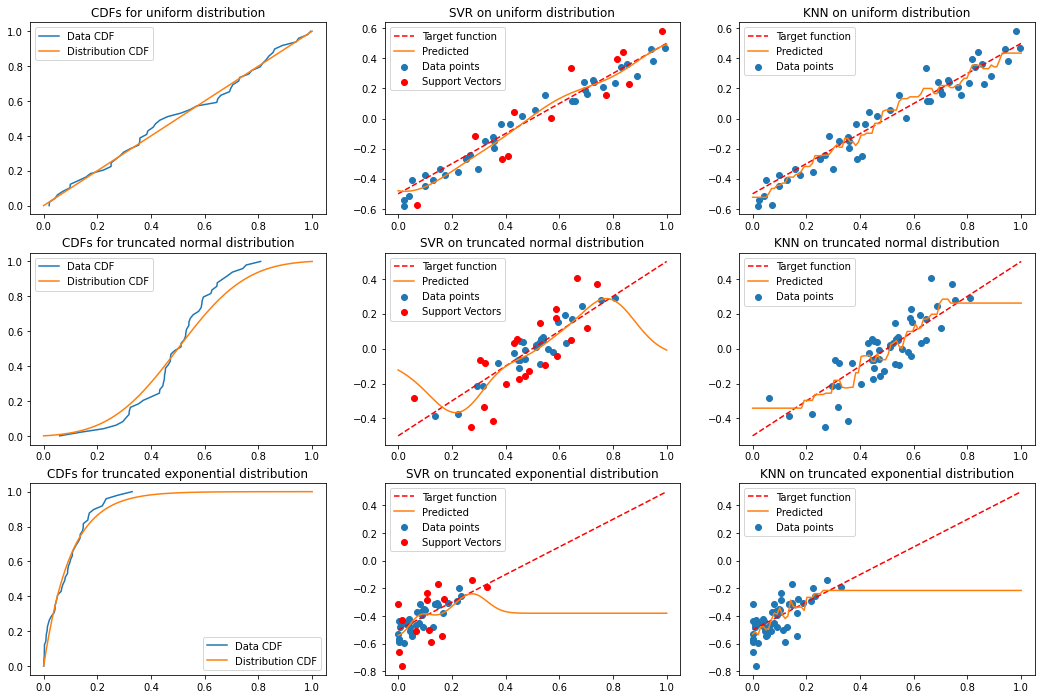

In [9]:
def plot_iteration_results(iteration_results):
    nrows, ncols = 3, 3
    fig, axss = plt.subplots(3, 3)
    multiply_fig_size(fig, nrows, ncols)
    plot_results(iteration_results, axss)

    for distr_name, result in iteration_results.items():
        print(f"{distr_name}\t - SVR: {result['svr_score']} - KNN: {result['knn_score']}")

def average_results(results):
    scores = [
        [[result[distr_name]['svr_score'], result[distr_name]['knn_score']] for distr_name in distr_names] for result in results
    ]
    scores = np.array(scores).mean(axis=0)
    df = pd.DataFrame(scores, columns=["SVR", "KNN"])
    df["Distributions"] = distr_names
    df = df[["Distributions", "SVR", "KNN"]]
    return df

df = average_results(results)

print(f"---- Average over {len(results)} iterations ----\n", df)
chosen_iteration = 0
print(f"---- Results for iteration {chosen_iteration} ----")
plot_iteration_results(results[0])



[-0.27274879  1.27274879]
[1.38155106]


(<module 'matplotlib.pyplot' from 'c:\\Users\\Admin\\anaconda3\\envs\\SFoML\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 <matplotlib.lines.Line2D at 0x204edbbe2e0>)

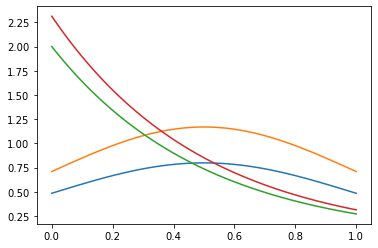

In [33]:
x_test = np.array([1, 2, 3, 4, 5])
y_test = np.array([6, 7, 8, 9, 10])
support_vectors = np.array([2, 4])

x_test[np.where([bool(x in support_vectors) for x in x_test])]

